# Mining Association Rules for tags

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)
cwd = Path('.')

In [2]:
%matplotlib inline

In [3]:
import nltk
from nltk.corpus import stopwords
from collections import OrderedDict
from itertools import combinations
STOPWORDS = set(stopwords.words('english'))

In [4]:
from random import seed
RANDOM = 42
seed(RANDOM)
np.random.seed(RANDOM)

In [5]:
df = pd.read_csv(cwd/'output'/"videos.csv")

In [6]:
df = df.drop_duplicates()
df = df.drop_duplicates(subset='video_id')

In [7]:
df.head()

,video_id,title,channel_title,category_id,tags,views,likes,dislikes,comment_total,thumbnail_link,date,likes_log,views_log,dislikes_log,comment_log,category_name,like_rate,dislike_rate,comment_rate
0,XpVt6Z1Gjjo,1 YEAR OF VLOGGING -- HOW LOGAN PAUL CHANGED Y...,Logan Paul Vlogs,24,logan paul vlog|logan paul|logan|paul|olympics...,4394029,320053,5931,46245,https://i.ytimg.com/vi/XpVt6Z1Gjjo/default.jpg,13.09,12.676245,15.295757,8.688117,10.741730,Entertainment,7.283816,0.134979,1.052451
1,K4wEI5zhHB0,iPhone X — Introducing iPhone X — Apple,Apple,28,Apple|iPhone 10|iPhone Ten|iPhone|Portrait Lig...,7860119,185853,26679,0,https://i.ytimg.com/vi/K4wEI5zhHB0/default.jpg,13.09,12.132717,15.877312,10.191670,0.000000,Science & Technology,2.364506,0.339422,0.000000
2,cLdxuaxaQwc,My Response,PewDiePie,22,[none],5845909,576597,39774,170708,https://i.ytimg.com/vi/cLdxuaxaQwc/default.jpg,13.09,13.264901,15.581253,10.590994,12.047716,People & Blogs,9.863257,0.680373,2.920128
3,WYYvHb03Eog,Apple iPhone X first look,The Verge,28,apple iphone x hands on|Apple iPhone X|iPhone ...,2642103,24975,4542,12829,https://i.ytimg.com/vi/WYYvHb03Eog/default.jpg,13.09,10.125671,14.787086,8.421343,9.459541,Science & Technology,0.945270,0.171909,0.485560
4,sjlHnJvXdQs,iPhone X (parody),jacksfilms,23,jacksfilms|parody|parodies|iphone|iphone x|iph...,1168130,96666,568,6666,https://i.ytimg.com/vi/sjlHnJvXdQs/default.jpg,13.09,11.479027,13.970916,6.343880,8.804925,Comedy,8.275278,0.048625,0.570656


In [8]:
df['tags'].head()

0    logan paul vlog|logan paul|logan|paul|olympics...
1    Apple|iPhone 10|iPhone Ten|iPhone|Portrait Lig...
2                                               [none]
3    apple iphone x hands on|Apple iPhone X|iPhone ...
4    jacksfilms|parody|parodies|iphone|iphone x|iph...
Name: tags, dtype: object

In [9]:
df['tags'][0]

'logan paul vlog|logan paul|logan|paul|olympics|logan paul youtube|vlog|daily|comedy|hollywood|parrot|maverick|bird|maverick clothes|diamond play button|logan paul diamond play button|10M subscribers|logan paul 1 year vlogging|1 year vlog|dwarf mamba play button|logan paul history|youtube history|10M|10M plaque|youtube button|diamond button|logang|logang 4 life'

In [10]:
df[df['tags']=='[none]'].head()

,video_id,title,channel_title,category_id,tags,views,likes,dislikes,comment_total,thumbnail_link,date,likes_log,views_log,dislikes_log,comment_log,category_name,like_rate,dislike_rate,comment_rate
2,cLdxuaxaQwc,My Response,PewDiePie,22,[none],5845909,576597,39774,170708,https://i.ytimg.com/vi/cLdxuaxaQwc/default.jpg,13.09,13.264901,15.581253,10.590994,12.047716,People & Blogs,9.863257,0.680373,2.920128
56,bAon04ZJhHE,Season 21 Preview: White People Renovating Houses,South Park Studios,20,[none],182676,3752,165,1163,https://i.ytimg.com/vi/bAon04ZJhHE/default.jpg,13.09,8.230311,12.115475,5.111988,7.059618,Gaming,2.053910,0.090324,0.636646
74,bp6uJJJMaLs,Things you need to know about Pennywise,Jenny Nicholson,1,[none],39338,2377,103,484,https://i.ytimg.com/vi/bp6uJJJMaLs/default.jpg,13.09,7.774015,10.579972,4.644391,6.184149,Film & Animation,6.042503,0.261833,1.230362
133,UpONjs5kLPc,Los jugadores de Sacachispas entraron vestidos...,Futbol La Pasion,17,[none],53712,203,4,25,https://i.ytimg.com/vi/UpONjs5kLPc/default.jpg,13.09,5.318120,10.891410,1.609438,3.258097,Sports,0.377942,0.007447,0.046545
164,c3pFWJCQy5E,Update: Problem with Chemo Pills,Courtelizz1,26,[none],108839,3677,107,732,https://i.ytimg.com/vi/c3pFWJCQy5E/default.jpg,13.09,8.210124,11.597634,4.682131,6.597146,Howto & Style,3.378385,0.098310,0.672553


In [11]:
records = df.apply(lambda row: row['tags'].split("|"), axis=1).tolist()

In [12]:
# Remove "" and "[none]" and change to lower case and strip leading and trailing whitespace
for i in range(len(records)):
    records[i] = [tag.lower().strip() for tag in records[i] if tag != "" and tag != "[none]"]
# Remove empty records
records = [record for record in records if len(record) != 0]        

#### How many unique tags

In [13]:
unique_tags = set()
for record in records:
    unique_tags.update(set(record))
len(unique_tags)

28281

In [14]:
unique_tags_and_counts = {} # tag:count
for unique_tag in tqdm(unique_tags):
    for record in records:
        if unique_tag not in record:
            continue
        if unique_tag not in unique_tags_and_counts:
            unique_tags_and_counts[unique_tag] = 1
        else:
            unique_tags_and_counts[unique_tag] += 1            

100%|██████████| 28281/28281 [00:26<00:00, 1083.41it/s]


In [15]:
# Just to see top 20 1-itemsets
sorted(list(unique_tags_and_counts.items()), key=lambda x: x[1], reverse=True)[:20]

[('funny', 325),
 ('comedy', 250),
 ('vlog', 140),
 ('2017', 140),
 ('makeup', 125),
 ('interview', 114),
 ('music', 113),
 ('how to', 112),
 ('humor', 112),
 ('news', 107),
 ('football', 104),
 ('beauty', 103),
 ('trailer', 102),
 ('video', 100),
 ('celebrity', 98),
 ('talk show', 93),
 ('tutorial', 91),
 ('review', 85),
 ('fashion', 84),
 ('food', 84)]

In [16]:
sns.set(style="white", font_scale=1.5)

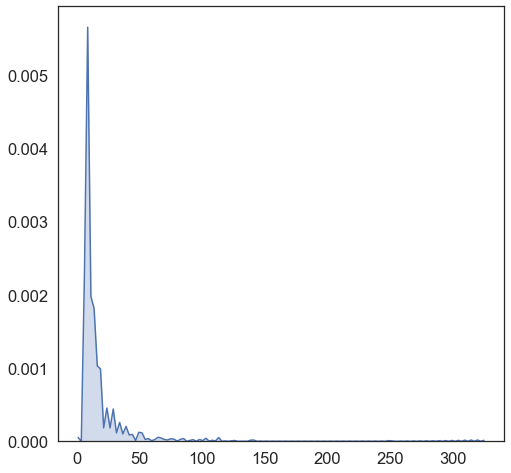

In [17]:
plt.figure(figsize=(8, 8))
sns.kdeplot([i[1] for i in unique_tags_and_counts.items()], shade=True)

In [18]:
# How many 1-itemsets have <= n occurence?
def less_than_n_occurence(n, unique_tags_and_counts):
    count = 0
    for k, v in unique_tags_and_counts.items():
        assert(v != 0)
        if v <= n:
            count += 1
    return count

In [19]:
# Change range to your liking
for i in range(1, 11, 1):
    count = less_than_n_occurence(i, unique_tags_and_counts)
    print(f"{count*100/len(unique_tags)}% of 1-itemsets have <= {i} occurrence")

75.12464198578552% of 1-itemsets have <= 1 occurrence
86.05424136345957% of 1-itemsets have <= 2 occurrence
90.79240479473852% of 1-itemsets have <= 3 occurrence
93.07662388175807% of 1-itemsets have <= 4 occurrence
94.62183091121247% of 1-itemsets have <= 5 occurrence
95.77808422615891% of 1-itemsets have <= 6 occurrence
96.5418478837382% of 1-itemsets have <= 7 occurrence
97.13588628407764% of 1-itemsets have <= 8 occurrence
97.50716028428981% of 1-itemsets have <= 9 occurrence
97.85721862734698% of 1-itemsets have <= 10 occurrence


In [20]:
min_sup = 0.005
min_sup_count = min_sup*len(records)

In [21]:
min_sup_count

15.41

In [22]:
frequent_one_itemset_with_counts = [item for item in sorted(list(unique_tags_and_counts.items()), key=lambda x: x[1], reverse=True)\
                                    if item[1] > min_sup_count]

In [23]:
frequent_one_itemset = [i[0] for i in frequent_one_itemset_with_counts]

In [24]:
frequent_one_itemset[:50]

['funny',
 'comedy',
 'vlog',
 '2017',
 'makeup',
 'interview',
 'music',
 'how to',
 'humor',
 'news',
 'football',
 'beauty',
 'trailer',
 'video',
 'celebrity',
 'talk show',
 'tutorial',
 'review',
 'fashion',
 'food',
 'television',
 'pop',
 'live',
 'celebrities',
 'funny video',
 'hollywood',
 'comedian',
 'science',
 'late night',
 'new',
 'clip',
 'diy',
 'show',
 'highlights',
 'jokes',
 'halloween',
 'nbc',
 'soccer',
 'highlight',
 'youtube',
 'sports',
 'games',
 'family',
 'fun',
 'vlogging',
 'comedic',
 'haul',
 'film',
 'recipe',
 'london']

In [25]:
# Change records to l-order
for i in range(len(records)):
    records[i] = [tag for tag in records[i] if tag in frequent_one_itemset]
    records[i] = sorted(records[i], key=lambda x: frequent_one_itemset.index(x), reverse=False)

In [26]:
records[:20]

[['comedy', 'vlog', 'hollywood', 'daily'],
 ['apple', 'iphone'],
 ['apple', 'iphone', 'iphone x'],
 ['apple', 'parody', 'iphone 8', 'iphone', 'iphone x'],
 ['comedy', 'trailer', 'film', 'movie', 'official', 'hd'],
 ['funny',
  'comedy',
  'humor',
  'talk show',
  'television',
  'late night',
  'nbc',
  'nbc tv',
  'parody',
  'satire',
  'host',
  'promo',
  'stand-up',
  'news satire'],
 ['iphone 8', 'iphone x', 'iphone x', 'iphone 8 plus'],
 ['vlog',
  'vlogging',
  'vlogger',
  'daily',
  'kids',
  'home',
  'house',
  'vlogs',
  'family friendly',
  'dog',
  'dog',
  'girlfriend',
  'day'],
 [],
 ['funny', 'comedy', 'humor', 'sketch', 'sketch comedy', 'amazon'],
 ['interview',
  'best',
  'lelepons',
  'alesso',
  'shots',
  'marshemllo',
  'marshmello',
  'hannahstocking',
  'anwar',
  'shotsstudios',
  'inannasarkis',
  'inanna',
  'rudymancuso'],
 ['funny',
  'interview',
  'humor',
  'video',
  'talk show',
  'television',
  'celebrities',
  'funny video',
  'clip',
  'show',

In [27]:
# Helper function to check if a list is a sublist of another
def sublist(ls1, ls2):
    def get_all_in(one, another):
        for element in one:
            if element in another:
                yield element

    for x1, x2 in zip(get_all_in(ls1, ls2), get_all_in(ls2, ls1)):
        if x1 != x2:
            return False
    return True

#### Implement FP-Tree and test with example from lecture notes

In [28]:
class FPTreeNode:
    
    def __init__(self, item=None, count=None, parent=None):
        self.root = False
        self.item = item
        self.count = count
        self.parent = parent
        self.children = []
        if parent == None:
            self.root = True
            self.item = "{}"
    
    def find_child_with_item(self, item):
        for child in self.children:
            if child.item == item:
                return child
        else:
            return None
        
    def add(self, record):
        if not self.root:
            while len(record) != 0 and self.item == record[0]:
                self.count += 1
                record.pop(0)
        if len(record) == 0:
            return
        child = self.find_child_with_item(record[0])
        if child != None:
            child.add(record)
        else:
            self.children.append(FPTreeNode(record[0], 1, self))
            self.children[-1].parent = self
            self.children[-1].add(record[1:])
    
    def show(self):
        # Only useful for development ...
        # BFS to print
        queue = []
        queue.append(self)
        queue.append(None) # as a delimiter
        while len(queue) > 1:
            cur = queue.pop(0)
            if cur == None:
                queue.append(None)
                print("\n")
            else:
                for child in cur.children:
                    queue.append(child)
                print(f"{cur.item}:{cur.count} ", end='')
    
    def get_cpb(self, item):
        # Get cpb end with item
        # First find the nodes of that item
        nodes = []
        # DFS to search for the nodes
        stack = []
        stack.append(self)
        while len(stack) > 0:
            cur = stack.pop()
            if cur.item == item:
                nodes.append(cur)
            for child in cur.children:
                stack.append(child)
        # Based on the nodes, find the cpb and count
        cpb_and_count = []
        for node in nodes:
            cpb = []
            cur = node
            while cur.parent and cur.parent.item != "{}":
                cpb.append(cur.parent.item)
                cur = cur.parent
            cpb.reverse()
            if len(cpb) == 0:
                continue
            cpb_and_count.append((cpb, node.count))
        cpb_and_count.reverse() # due to stack
        return cpb_and_count
    
    def get_cft(self, item, min_count):
        cpb_and_count = self.get_cpb(item)
        cft = OrderedDict()
        for (pattern, count) in cpb_and_count:
            for item in pattern:
                if item not in cft:
                    cft[item] = count
                else:
                    cft[item] += count
        filtered_cft = OrderedDict()
        for k, v in cft.items():
            if v >= min_count:
                filtered_cft[k] = v
        return filtered_cft
    
    def get_frequent_itemsets(self, one_itemset_list, min_sup_count):
        cft_list = [self.get_cft(i, min_sup_count) for i in one_itemset_list]
        frequent_itemsets = []
        for i in range(len(cft_list)):
            cft_items = list(cft_list[i])
            end_base = one_itemset_list[i]
            frequent_itemsets.append([end_base])
            if len(cft_items) == 0:
                continue
            for i in range(1, len(cft_items)+1):
                i_combinations = [list(j) for j in list(combinations(cft_items, i))]
                for i_combination in i_combinations:
                    i_combination.append(end_base)
                frequent_itemsets.extend(i_combinations)
        return frequent_itemsets
    
    def get_maximal_frequent_itemsets(self, one_itemset_list, min_sup_count, at_least_two=True):
        cft_list = [self.get_cft(i, min_sup_count) for i in one_itemset_list]
        frequent_itemsets = []
        for i in range(len(cft_list)):
            cft_items = list(cft_list[i].items())
            if at_least_two and len(cft_items) == 0:
                continue
            min_count_in_cft = min([i[1] for i in cft_items])
            end_base = one_itemset_list[i]
            cft_items_w_count = ([i[0] for i in cft_items] + [end_base], min_count_in_cft) 
            frequent_itemsets.append(cft_items_w_count)
        remove_idx = set()
        for i in range(len(frequent_itemsets)):
            for j in range(len(frequent_itemsets)):
                if j == i:
                    continue
                if set(frequent_itemsets[i][0]).issubset(set(frequent_itemsets[j][0])):
                    remove_idx.add(i)
        frequent_itemsets = [frequent_itemsets[i] for i in range(len(frequent_itemsets)) if i not in remove_idx]
        return frequent_itemsets

In [29]:
test_records = [
    ['f', 'c', 'a', 'm', 'p'],
    ['f', 'c', 'a', 'b', 'm'],
    ['f', 'b'],
    ['c', 'b', 'p'],
    ['f', 'c', 'a', 'm', 'p']
]

In [30]:
fp_tree = FPTreeNode()

In [31]:
for test_record in test_records:
    fp_tree.add(test_record)

In [32]:
fp_tree.show()

{}:None 

f:4 c:1 

c:3 b:1 b:1 

a:3 p:1 

m:2 b:1 

p:2 m:1 

In [33]:
for char in "pmbacf":
    print(fp_tree.get_cpb(char))

[(['f', 'c', 'a', 'm'], 2), (['c', 'b'], 1)]
[(['f', 'c', 'a'], 2), (['f', 'c', 'a', 'b'], 1)]
[(['f', 'c', 'a'], 1), (['f'], 1), (['c'], 1)]
[(['f', 'c'], 3)]
[(['f'], 3)]
[]


In [34]:
list(fp_tree.get_cft('m', 3).items())

[('f', 3), ('c', 3), ('a', 3)]

In [35]:
for char in "pmbacf":
    print(fp_tree.get_cft(char, 3))

OrderedDict([('c', 3)])
OrderedDict([('f', 3), ('c', 3), ('a', 3)])
OrderedDict()
OrderedDict([('f', 3), ('c', 3)])
OrderedDict([('f', 3)])
OrderedDict()


In [36]:
fp_tree.get_frequent_itemsets("pmbacf", 3)

[['p'],
 ['c', 'p'],
 ['m'],
 ['f', 'm'],
 ['c', 'm'],
 ['a', 'm'],
 ['f', 'c', 'm'],
 ['f', 'a', 'm'],
 ['c', 'a', 'm'],
 ['f', 'c', 'a', 'm'],
 ['b'],
 ['a'],
 ['f', 'a'],
 ['c', 'a'],
 ['f', 'c', 'a'],
 ['c'],
 ['f', 'c'],
 ['f']]

In [37]:
fp_tree.get_maximal_frequent_itemsets("pmbacf", 3)

[(['c', 'p'], 3), (['f', 'c', 'a', 'm'], 3)]

In [38]:
def get_non_empty_subsets(frequent_itemset):
    # NOTE: for frequent itemset of size n, only segment into pairs of subsets of sizes 1, n-1
    # RATIONALE: save time, and it is pointless as we will find out later
    clone = frequent_itemset[0][:]
    frequent_itemset = set(frequent_itemset[0])
    rule_combinations = [set(j) for j in list(combinations(frequent_itemset, 1))]
    rule_combinations = [[j, frequent_itemset.difference(j)] for j in rule_combinations]
    for rule_combination in rule_combinations:
        rule_combination[0] = sorted(list(rule_combination[0]), key=lambda x: clone.index(x), reverse=False)
        rule_combination[1] = sorted(list(rule_combination[1]), key=lambda x: clone.index(x), reverse=False)
    return rule_combinations

In [39]:
get_non_empty_subsets((['f', 'c', 'a', 'm'], 3))

[[['c'], ['f', 'a', 'm']],
 [['a'], ['f', 'c', 'm']],
 [['m'], ['f', 'c', 'a']],
 [['f'], ['c', 'a', 'm']]]

Looks good, now for actual dataset

In [40]:
# Encode into integer 
counter = 0
item_to_int_map = {}
int_to_item_map = {}
for record in records:
    for item in record:
        if item in item_to_int_map:
            continue
        item_to_int_map[item] = counter
        int_to_item_map[counter] = item
        counter += 1

In [41]:
for i in range(len(records)):
    for j in range(len(records[i])):
        records[i][j] = item_to_int_map[records[i][j]]
for i in range(len(frequent_one_itemset)):
    frequent_one_itemset[i] = item_to_int_map[frequent_one_itemset[i]]

In [42]:
fp_tree = FPTreeNode()
for record in records:
    fp_tree.add(record)

In [43]:
min_sup_count

15.41

In [44]:
# Focus on maximal only. RAM no space to store all and maximal is more meaningful
maximal_frequent_itemsets = fp_tree.get_maximal_frequent_itemsets(frequent_one_itemset, min_sup_count)

In [45]:
def get_rule(records, no_conf_rule):
    itemset = no_conf_rule[0] + no_conf_rule[1]
    support_count_total = 0
    support_count_lhs = 0
    for record in records:
        if sublist(itemset, record):
            support_count_total += 1
        if sublist(no_conf_rule[0], record):
            support_count_lhs += 1
    return no_conf_rule + [support_count_total/len(records), support_count_total/support_count_lhs]

In [46]:
rules = []
for frequent_itemset in tqdm(maximal_frequent_itemsets):
    no_conf_rules = get_non_empty_subsets(frequent_itemset)
    for no_conf_rule in no_conf_rules:
        rules.append(get_rule(records, no_conf_rule))

100%|██████████| 98/98 [00:03<00:00, 30.35it/s]


In [47]:
# min confidence of rules
min([rule[3] for rule in rules])

0.990590525632706

Means that if you permutate all possible rules of a maximal frequent set for all maximal frequent sets, the worst confidence of a rule is 99.4%

The existence of an item in maximal frequent set means implies item -> the rest of the items in the maximal frequent set with confidence of at least 99.4%

We can simply analyze maximal frequent itemset

In [48]:
# Convert to item names
for i in range(len(maximal_frequent_itemsets)):
    for j in range(len(maximal_frequent_itemsets[i][0])):
        maximal_frequent_itemsets[i][0][j] = int_to_item_map[maximal_frequent_itemsets[i][0][j]]

In [52]:
len(maximal_frequent_itemsets)

98

In [49]:
# Sort of frequency
maximal_frequent_itemsets.sort(key=lambda x: x[1], reverse=True)

In [50]:
maximal_frequent_itemsets

[(['funny',
   'comedy',
   'humor',
   'celebrity',
   'celebrities',
   'funny video',
   'hollywood',
   'comedian',
   'late night',
   'talk show',
   'interview',
   'video',
   'television',
   'clip',
   'show',
   'jokes'],
  29),
 (['funny',
   'interview',
   'humor',
   'video',
   'talk show',
   'television',
   'celebrities',
   'funny video',
   'clip',
   'show',
   'jokes',
   'nbc',
   'highlight',
   'comedic',
   'snl',
   'nbc tv',
   'talent',
   'variety',
   'jimmy fallon',
   'tonight',
   'fallon monologue',
   'the tonight show',
   'comedy sketches',
   'fallon stand-up'],
  29),
 (['technology', 'tech'], 28),
 (['nba', 'basketball'], 28),
 (['trailer', 'official trailer'], 25),
 (['funny', 'fun'], 24),
 (['funny', 'comedy', 'late night', 'host'], 23),
 (['funny', 'how to', 'vlog', 'makeup', 'beauty', 'tutorial'], 22),
 (['funny',
   'comedy',
   'humor',
   'talk show',
   'comedian',
   'clip',
   'show',
   'television',
   'interview',
   'video',
   'c